# **Predicción de Condiciones Óptimas para Generación Solar mediante Modelos de ML**

Problema:
Predecir si las condiciones ambientales son óptimas para máxima generación de energía solar (binario: Sí/No).

Objetivo:
Desarrollar un modelo de clasificación que, usando variables meteorológicas, prediga ventanas de alta eficiencia energética.

In [1]:
# En esta celda importamos todas las librerías necesarias para el análisis.
# También, se lee el archivo desde Github que contiene los datos con los que trabajaremos.
# Realizamos también una pequeña exploración de los datos.

import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from seaborn import countplot
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

# Leemos el archivo desde Github
url = "https://raw.githubusercontent.com/DaveLeal/Diplomado-Python-UAEM/refs/heads/main/Proyecto%20final/Esolmet_IER-UNAM.csv"
df = pd.read_csv(url, sep=',', parse_dates=['Timestamp'])
display(df.head())
print()
print(f'La forma del dataset es de:', df.shape)

,Timestamp,"""I_dir [W/m2]""","""I_glo[W/m2]""","""I_dif[W/m2]""","""Iglo_inc[W/m2]""","""Indice_UV[W/m2]""","""Indice_UVA[W/m2]""","""AirTC[°C]""","""HR[%]""","""WS[m/s]""","""WD[grados]""","""PB[mbar]""","""Rain[mm]"""
0,"5/7/2025, 12:10:00",801.0,1,4.0,164.6,909.00,0.21,63.62,27.83,61.56,2.39,1.55,865.99
1,"5/7/2025, 12:00:00",810.0,1,1.0,168.0,912.00,0.21,63.65,28.14,58.81,1.13,1.54,866.28
2,"5/7/2025, 11:50:00",798.6,978,170.4,892.0,0.21,62.18,27.49,60.57,1.38,103.60,866.45,0.00
3,"5/7/2025, 11:40:00",812.0,974,176.8,891.0,0.20,62.09,26.61,63.42,1.42,1.54,866.63,0.00
4,"5/7/2025, 11:30:00",823.0,962,188.9,883.0,0.20,61.46,26.76,62.28,1.51,314.20,866.76,0.00



La forma del dataset es de: (56984, 13)


In [2]:
df.dtypes #Vemos los tipos de datos de nuestro data frame

,0
Timestamp,object
"""I_dir [W/m2]""",float64
"""I_glo[W/m2]""",object
"""I_dif[W/m2]""",float64
"""Iglo_inc[W/m2]""",float64
"""Indice_UV[W/m2]""",float64
"""Indice_UVA[W/m2]""",float64
"""AirTC[°C]""",float64
"""HR[%]""",float64
"""WS[m/s]""",float64


In [3]:
#Cambiamos la columna de la irradiencia global de "object" a "float"
df[' "I_glo[W/m2]"'] = df[' "I_glo[W/m2]"'].str.replace(',', '.').astype(float)

In [4]:
df.dtypes #Vemos los tipos de datos de nuestro data frame

,0
Timestamp,object
"""I_dir [W/m2]""",float64
"""I_glo[W/m2]""",float64
"""I_dif[W/m2]""",float64
"""Iglo_inc[W/m2]""",float64
"""Indice_UV[W/m2]""",float64
"""Indice_UVA[W/m2]""",float64
"""AirTC[°C]""",float64
"""HR[%]""",float64
"""WS[m/s]""",float64


In [5]:
df.isna().sum()

,0
Timestamp,86
"""I_dir [W/m2]""",122
"""I_glo[W/m2]""",124
"""I_dif[W/m2]""",122
"""Iglo_inc[W/m2]""",122
"""Indice_UV[W/m2]""",122
"""Indice_UVA[W/m2]""",122
"""AirTC[°C]""",122
"""HR[%]""",122
"""WS[m/s]""",122


Notamos que hay datos faltantes en varias líneas. Limpiamos estas líneas.

In [6]:
# Eliminar las filas que tienen elementos NaN
# Estos datos faltantes son debido a la forma en que se tuvo que obtener la información
# desde la plataforma original

# Usamos la columna con más datos faltantes
column_to_check = ' "I_glo[W/m2]"'
df_cleaned = df.dropna(subset=[column_to_check])

print(f'La forma del dataset después de eliminar NaNs en "{column_to_check}" es de:', df_cleaned.shape)

# Corroboramos si hay datos faltantes
print('\nNúmero de NaNs por columna después de la limpieza:')
print(df_cleaned.isna().sum())

La forma del dataset después de eliminar NaNs en " "I_glo[W/m2]"" es de: (56860, 13)

Número de NaNs por columna después de la limpieza:
Timestamp              0
 "I_dir [W/m2]"        0
 "I_glo[W/m2]"         0
 "I_dif[W/m2]"         0
 "Iglo_inc[W/m2]"      0
 "Indice_UV[W/m2]"     0
 "Indice_UVA[W/m2]"    0
 "AirTC[°C]"           0
 "HR[%]"               0
 "WS[m/s]"             0
 "WD[grados]"          0
 "PB[mbar]"            0
 "Rain[mm]"            0
dtype: int64


Cambiamos el nombre de la columna por algo más explícito y en español

In [7]:
df_cleaned = df_cleaned.rename(columns={'Timestamp':'Marca de tiempo',
                                       ' "WS[m/s]"': 'Viento (m/s)',
                                       ' "WD[grados]"':'Direccion_viento (grados)',
                                        ' "I_dir [W/m2]"':'I_dir (W/m2)',
                                        ' "I_glo[W/m2]"':'I_glo (W/m2)',
                                        ' "I_dif[W/m2]"':'I_dif (W/m2)',
                                        ' "Iglo_inc[W/m2]"':'Iglo_inc (W/m2)',
                                        ' "Indice_UV[W/m2]"':'Indice_UV (W/m2)',
                                        ' "Indice_UVA[W/m2]"':'Indice_UVA (W/m2)',
                                        ' "AirTC[°C]"':'Temp aire (°C)',
                                        ' "HR[%]"':'HR (%)',
                                        ' "PB[mbar]"':'PB (mbar)',
                                        ' "Rain[mm]"':'Lluvia (mm)',})

print(f'\nColumnas después de renombrar:')
print(df_cleaned.columns)
print()
display(df_cleaned.head())


Columnas después de renombrar:
Index(['Marca de tiempo', 'I_dir (W/m2)', 'I_glo (W/m2)', 'I_dif (W/m2)',
       'Iglo_inc (W/m2)', 'Indice_UV (W/m2)', 'Indice_UVA (W/m2)',
       'Temp aire (°C)', 'HR (%)', 'Viento (m/s)', 'Direccion_viento (grados)',
       'PB (mbar)', 'Lluvia (mm)'],
      dtype='object')



,Marca de tiempo,I_dir (W/m2),I_glo (W/m2),I_dif (W/m2),Iglo_inc (W/m2),Indice_UV (W/m2),Indice_UVA (W/m2),Temp aire (°C),HR (%),Viento (m/s),Direccion_viento (grados),PB (mbar),Lluvia (mm)
0,"5/7/2025, 12:10:00",801.0,1.0,4.0,164.6,909.00,0.21,63.62,27.83,61.56,2.39,1.55,865.99
1,"5/7/2025, 12:00:00",810.0,1.0,1.0,168.0,912.00,0.21,63.65,28.14,58.81,1.13,1.54,866.28
2,"5/7/2025, 11:50:00",798.6,978.0,170.4,892.0,0.21,62.18,27.49,60.57,1.38,103.60,866.45,0.00
3,"5/7/2025, 11:40:00",812.0,974.0,176.8,891.0,0.20,62.09,26.61,63.42,1.42,1.54,866.63,0.00
4,"5/7/2025, 11:30:00",823.0,962.0,188.9,883.0,0.20,61.46,26.76,62.28,1.51,314.20,866.76,0.00


In [8]:
# Crear variable target
df_cleaned['target'] = (df_cleaned['I_glo (W/m2)'] >= 600).astype(int)

# Verificar balanceo
print("Distribución de clases:\n", df_cleaned['target'].value_counts(normalize=True))

Distribución de clases:
 target
0    0.808477
1    0.191523
Name: proportion, dtype: float64


In [9]:
#Extraemos las características temporales y ajustamos el formato que espera Pandas
df_cleaned['Marca de tiempo'] = pd.to_datetime(df_cleaned['Marca de tiempo'], format='%d/%m/%Y, %H:%M:%S')
df_cleaned['hora'] = df_cleaned['Marca de tiempo'].dt.hour
df_cleaned['mes'] = df_cleaned['Marca de tiempo'].dt.month

# Calcular la razón de irradiancia difusa/global como proxy de nubosidad
df_cleaned['razon_difusa_global'] = df_cleaned['I_dif (W/m2)'] / (df_cleaned['I_glo (W/m2)'] + 1e-6)  # Evitar división por cero

# Separamos variables y nuestro target
# Es importante que quitemos la irradiancia global, ya que queremos predecir el
# target a partir de las otras variables.
X = df_cleaned.drop(['target', 'Marca de tiempo', 'I_glo (W/m2)'], axis=1)
y = df_cleaned['target'].values

División Train-Test y balanceo

In [10]:
# Ahora dividimos los datos en conjuntos de entrenamiento, validación y prueba.
# Para ello, usamos la función train_test_split de scikit-learn.
# El argumento stratify se utiliza para mantener la proporción de clases en los
# conjuntos de entrenamiento y prueba.
# Finalmente, imprimimos las dimensiones de los conjuntos resultantes.

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.15,
                                                    stratify = y,
                                                    random_state=423)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2,
                                                  stratify = y_train,
                                                  random_state=423)

print(X_train.shape, X_val.shape, X_test.shape)

(38664, 14) (9667, 14) (8529, 14)


Calculamos los pesos de las clases para nuestros datos de entrenamiento y hacemos control de escalas.

In [11]:
class_weights = compute_class_weight('balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}
class_weights

{0: np.float64(0.6184458875843757), 1: np.float64(2.6106684672518568)}

In [12]:
# Realizamos escalamiento de variables cuidando que no haya data leakage.

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Definimos funciones para crear y configurar modelos de redes neuronales secuenciales usando *Keras*.

In [13]:
# Definimos una función con base en «opcion» para crear un modelo de red neuronal.
# La diferencia de las dos opciones es el número de capas y neuronas.

def build_model(opcion=1): #Tras probar ambos modelos, la opción 1 funciona mejor.
    if opcion == 1:
        model = Sequential()
        model.add(Input(shape=(X_train.shape[1],)))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['recall'])
        return model
    elif opcion == 2:
        model = Sequential()
        model.add(Input(shape=(X_train.shape[1],)))
        model.add(Dense(46, activation='relu'))
        model.add(Dense(21, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['recall'])
        return model
    else:
        print("Opción no valida")

#-----------------------

model = build_model(opcion=1)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129 (516.00 B)

 Trainable params: 129 (516.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Definimos un parámetro de parada temprana para evitar el sobreajuste.

callback_es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=3,
                   restore_best_weights=True
                   )

In [15]:
# Definimos el entrenador del modelo usando los datos de entrenamiento y validación.

history = model.fit(X_train, y_train,
                    epochs=40,
                    batch_size=256,
                    class_weight=class_weights,
                    validation_data=(X_val, y_val),
                    callbacks=[callback_es])

Epoch 1/40
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.6818 - recall: 0.9743 - val_loss: 0.4909 - val_recall: 0.9158
Epoch 2/40
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4418 - recall: 0.9198 - val_loss: 0.3166 - val_recall: 0.9627
Epoch 3/40
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2838 - recall: 0.9592 - val_loss: 0.2351 - val_recall: 0.9703
Epoch 4/40
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2136 - recall: 0.9659 - val_loss: 0.2018 - val_recall: 0.9735
Epoch 5/40
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1844 - recall: 0.9711 - val_loss: 0.1831 - val_recall: 0.9773
Epoch 6/40
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1683 - recall: 0.9737 - val_loss: 0.1666 - val_recall: 0.9795
Epoch 7/40
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1538 - recall: 0.9798 - val_loss: 0.1551 - val_recall: 0.9806
Epoch 8/40
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1397 - recall: 0.9835 - val_loss: 0.1405 - val_recall: 0.9806
Epoch 9

Visualicemos cómo se comporta nuestro modelo.

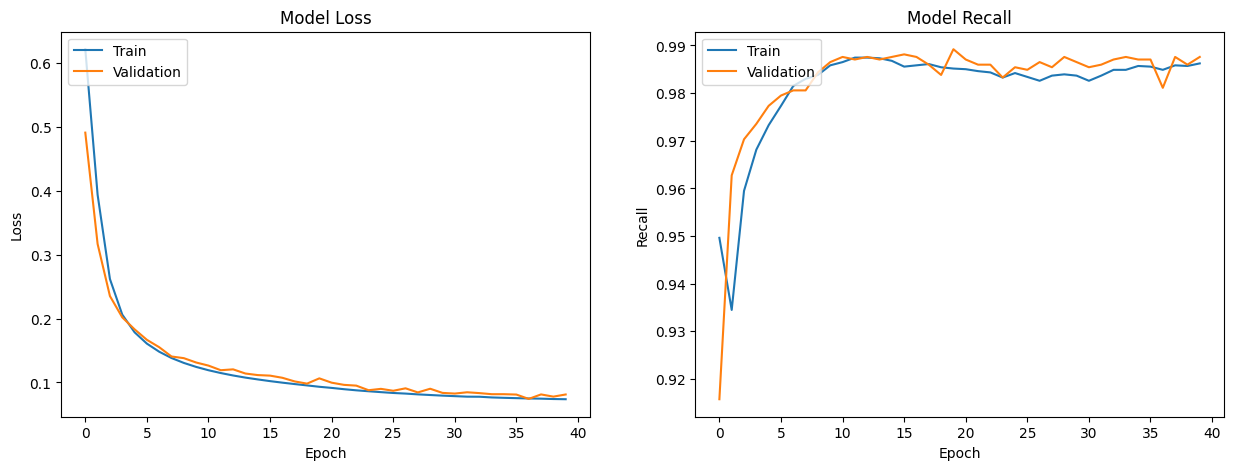

In [16]:
# Con este código generamos dos gráficas para visualizar el historial de
# entrenamiento del modelo con Recall y Model Loss

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[1].plot(history.history['recall'])
axs[1].plot(history.history['val_recall'])
axs[1].set_title('Model Recall')
axs[1].set_ylabel('Recall')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper left')
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Model Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper left')
fig.show()

In [17]:
# Calculamos y convertimos las probanilidades predichas a predicciones binarias
y_pred = (model.predict(X_test) > 0.5).astype(int)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.9704537460429125
Recall: 0.9871402327005512
Precision: 0.8746608790016278
F1 Score: 0.9275028768699655


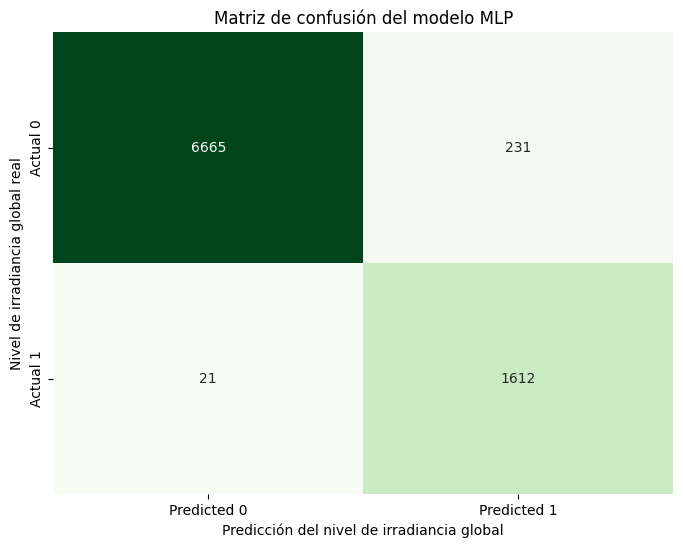

In [18]:
# Generamos y mostramos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicción del nivel de irradiancia global')
plt.ylabel('Nivel de irradiancia global real')
plt.title('Matriz de confusión del modelo MLP')
plt.show()

Tenemos una alta *Accuracy*, pero una relativamente baja *Precision*, lo que causa que haya muchos falsos positivos.

Analicemos el problema, pero ahora usando el **clasificador Random Forest** sin redes neuronales.

In [19]:
# Split estratificado
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Balanceo con SMOTE (si hay desbalance)

# smote = SMOTE(random_state=42)
# X_train_bal, y_train_bal = smote.fit_resample(X_train_RF, y_train_RF)

In [21]:
# Modelo base Random Forest para clasificación
model_2 = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    class_weight='balanced', #Random Forest puede lidiar con el desbalance de clases, por eso no se usó SMOTE en la celda anterior.
    random_state=42,
    min_samples_split=2 #Default
)
model_2.fit(X_train_RF, y_train_RF)

# Evaluación
y_pred_RF = model_2.predict(X_test_RF)
print(classification_report(y_test_RF, y_pred_RF))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     13791
           1       0.96      0.99      0.98      3267

    accuracy                           0.99     17058
   macro avg       0.98      0.99      0.98     17058
weighted avg       0.99      0.99      0.99     17058



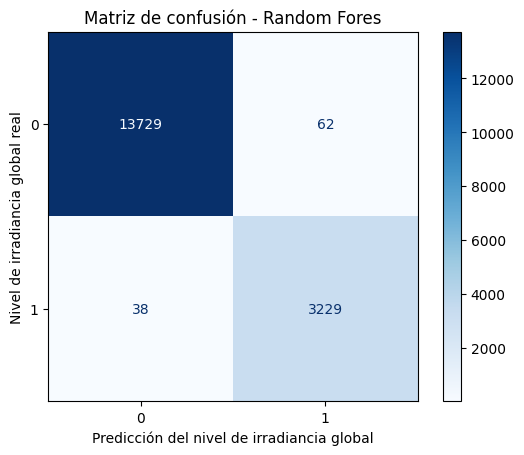

In [25]:
# Usemos nuevamente la matriz de confusión para ver si el modelo está funcionando.
ConfusionMatrixDisplay.from_estimator(model_2, X_test_RF, y_test_RF, cmap='Blues')
plt.title("Matriz de confusión - Random Fores")
plt.xlabel('Predicción del nivel de irradiancia global')
plt.ylabel('Nivel de irradiancia global real')
plt.show()

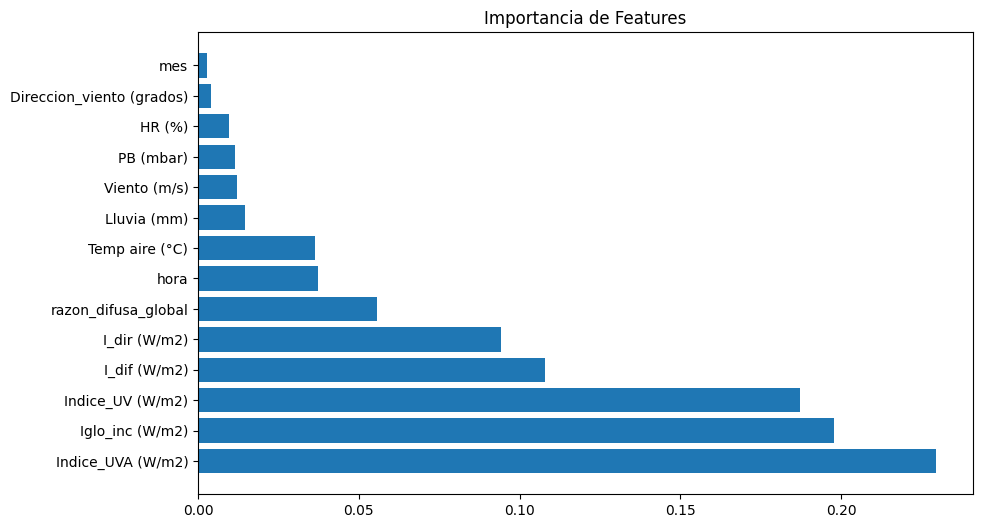

In [23]:
# Visualicemos las características más importantes del modelo.

importancias = model_2.feature_importances_
indices = np.argsort(importancias)[::-1]

# Obtenemos los nombres de las variables desde los datos de entrenamiento
features = X_train_RF.columns

plt.figure(figsize=(10, 6), )
plt.title("Importancia de Features")
plt.barh(range(len(indices)), importancias[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.show()

In [42]:
# Generamos un Grid Search para encontrar los mejores parámetros para el modelo.
# Esto toma alrededor de 7 minutos usando GPU.
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 8, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=model_2,
    param_grid=param_grid,
    scoring='f1',
    cv=5
)
grid_search.fit(X_train_RF, y_train_RF)

print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


In [24]:
# Modelo base con los mejores parámetros encontrados en el Grid Search
model_2 = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    min_samples_split=5 #Default
)
model_2.fit(X_train_RF, y_train_RF)

# Evaluación
y_pred_RF = model_2.predict(X_test_RF)
print(classification_report(y_test_RF, y_pred_RF))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13791
           1       0.98      0.99      0.98      3267

    accuracy                           0.99     17058
   macro avg       0.99      0.99      0.99     17058
weighted avg       0.99      0.99      0.99     17058



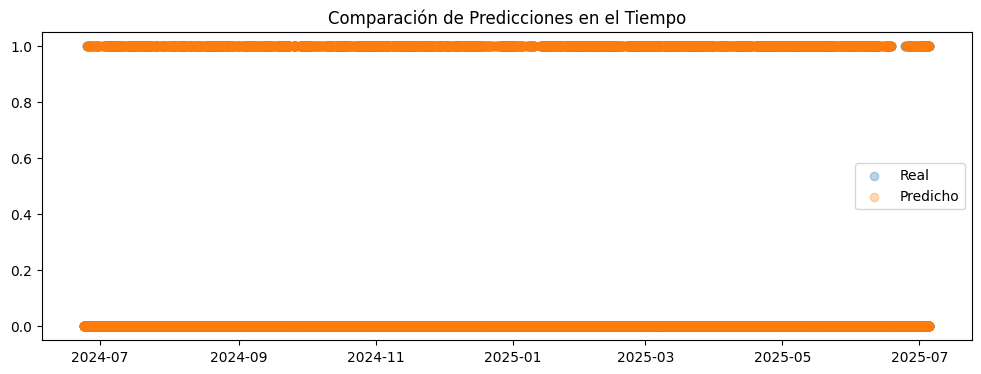

In [44]:
# Visualicemos cómo se comporta nuestro modelo al comparar las predicciones con las reales.
test_dates = df_cleaned.loc[X_test_RF.index, 'Marca de tiempo']
plt.figure(figsize=(12, 4))
plt.scatter(test_dates, y_test_RF, label='Real', alpha=0.3)
plt.scatter(test_dates, y_pred_RF, label='Predicho', alpha=0.3)
plt.title("Comparación de Predicciones en el Tiempo")
plt.legend()
plt.show()

**Conclusiones**

1.   El modelo es útil para predecir ventanas de alta generación de enrgía, por lo que es posible planificar mantenimiento en periodos de baja producción.
2.   Variables como irradiancia global y los índices UV y UVA son críticas
3.   La variable "nubosidad" o "razón_difusa_global" no fue relevante.




